<a href="https://colab.research.google.com/github/alanspace/Python_for_stock/blob/main/Stock_price_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Description
The program uses an artifical Recurrent Nerual Network (RNN) called Long Short Term Memory (LSTM) to predict the closing stock price of a corporation, like Apple Inc. using the past 60 day stock price.
Firstly, we import the library for computation processing.  



In [1]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# Get the stock quote
We ger the stock quote from the website yahoo using `web.DataReader()`, specifying the start date and end date of data extraction. Then we show the dataframe by commaning `df`.

In [2]:
df = web.DataReader('AAPL', data_source = 'yahoo', start = '2012-01-01', end = '2021-1-10')
#Show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.669562
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.737653
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.879066
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.013701
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.993060
...,...,...,...,...,...,...
2021-01-04,133.610001,126.760002,133.520004,129.410004,143301900.0,129.410004
2021-01-05,131.740005,128.429993,128.889999,131.009995,97664900.0,131.009995
2021-01-06,131.050003,126.379997,127.720001,126.599998,155088000.0,126.599998


High is the highest price the stock reached that day and then low refers to the lowest price the stock was traded on the same day. Open is the price on the open day of the stock market.Close is the price of the last trade when the market closed at 16:00 EST that day. It takes a few minutes to settle because of orders entered at the close, but a few a minutes after 16:00 you will see the last price stop changing. It will become the closing price and agrees with what is reported in the newspaprer. The adjusted close is usually the after hours price and the true open price adjusted from the close price posted. Volume refers to the number of share traded that day. To find the change, we need to substract Close from Open (strictly speaking, substract today's close from yesterday's close).

Before that, we now get the number of rows and columns in the dataset.
 

In [3]:
df.shape

(2270, 6)

To visualize the closing price history, we now plot the graph by calling `plt.fifure()` with the size (16, 8) and show it by `plt.show()`.

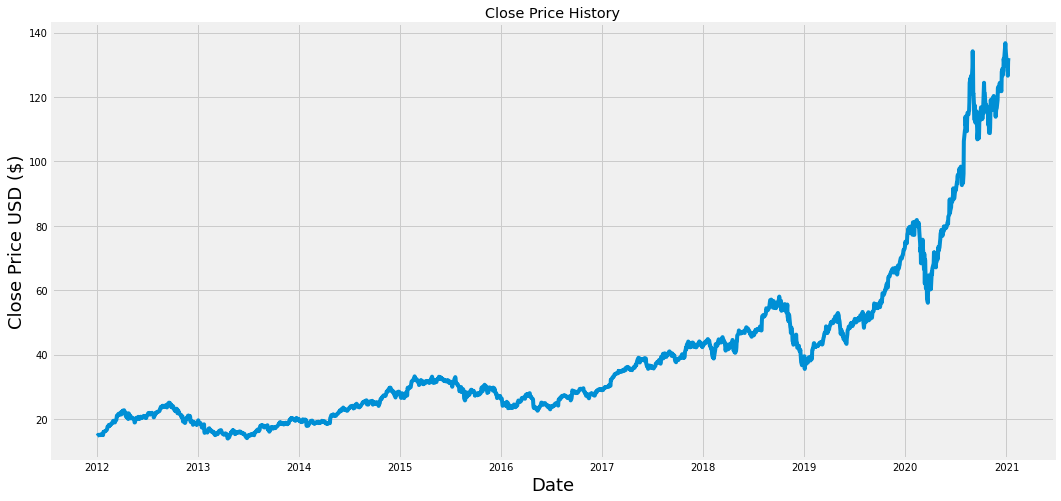

In [4]:
# Visusalize the closing price history
plt.figure(figsize = (16, 8))
plt.title('Close Price History')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD ($)', fontsize = 18)
plt.show()

From the above plot, we observe that Appl.Inc keep increasing in stock price, and even accelerate from 2019 to 2021.We only interested in the Close column only, so we create this column and convert the data frame to numpy array.We then get the number of rows to train the model. 

In [7]:
data = df.filter(['Close'])

dataset = data.values

training_data_len = math.ceil( len(dataset) * .8 )

training_data_len

1816

We set the sacler to scale the data by using the method `MinMaxScaler()`.

In [8]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00602306],
       [0.0066661 ],
       [0.00800165],
       ...,
       [0.91779535],
       [0.95299098],
       [0.96219729]])

Now the training data set and the scaled training data set can be created. We split the data into x_train and y_train data sets by calling two lists. We trade the stock price and predict the stock price after 60 days.

In [9]:
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i,0])
  if i <= 60:
    print(x_train)
    print(y_train)
    print()

[array([0.00602306, 0.0066661 , 0.00800165, 0.00927319, 0.00907824,
       0.0095176 , 0.00931683, 0.0089793 , 0.00851957, 0.00994242,
       0.01122559, 0.01082987, 0.00866214, 0.01073094, 0.00869416,
       0.0163321 , 0.01574144, 0.0165125 , 0.01817975, 0.01918941,
       0.01910503, 0.0187937 , 0.02012052, 0.02136877, 0.02278289,
       0.025067  , 0.02986508, 0.02993782, 0.03260892, 0.03460496,
       0.03117444, 0.03249544, 0.03246925, 0.03617329, 0.03564663,
       0.03662137, 0.03837301, 0.03934777, 0.04215562, 0.04420112,
       0.04479179, 0.04499838, 0.04150094, 0.04065712, 0.04078224,
       0.0440702 , 0.04499548, 0.0469828 , 0.0516674 , 0.05791742,
       0.05674772, 0.05675062, 0.06126938, 0.0626835 , 0.06167673,
       0.06075728, 0.05979999, 0.06298027, 0.06516255, 0.06607619])]
[0.06381826722571945]



convert the x_train and y_train to numpy array

In [10]:
x_train, y_train = np.array(x_train), np.array(y_train)


We reshape the data. 

In [11]:
x_train.shape

(1756, 60)

In [12]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1756, 60, 1)

Here we build the LSTM model and compile it. Then we train the model with the batch_zie =1, epoches =1.

In [13]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dense(units=25))
model.add(Dense(units=1))

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
model.fit(x_train, y_train, batch_size=1, epochs=1)

1756/1756 [==============================] - 34s 18ms/step - loss: 7.0223e-04


After training the data, we test it. We put the data generated by creating two lists for test data. 
Get all of the rows from index to the rest and all of the columns (in this case it's only column 'Close').
We then convert x_test to a numpy array, reshape the data into the shape accepted by the LSTM. Finally, we get the models predicted price values. 
We do the `inverse_transform` is to undo scaling.
To chck if the model is accurate enough, we get the value of RMSE.

In [18]:
test_data = scaled_data[training_data_len - 60: , : ]

x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [19]:
x_test = np.array(x_test)

In [20]:
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [21]:
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)

In [22]:
rmse=np.sqrt(np.mean(((predictions- y_test)**2)))
rmse

3.0635631953171774

After gathering the information, now we can plot the graph with the predicted sotkct price and the training data, i.e. the history stock price. For comparison, we show the the valid and predicted prices.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


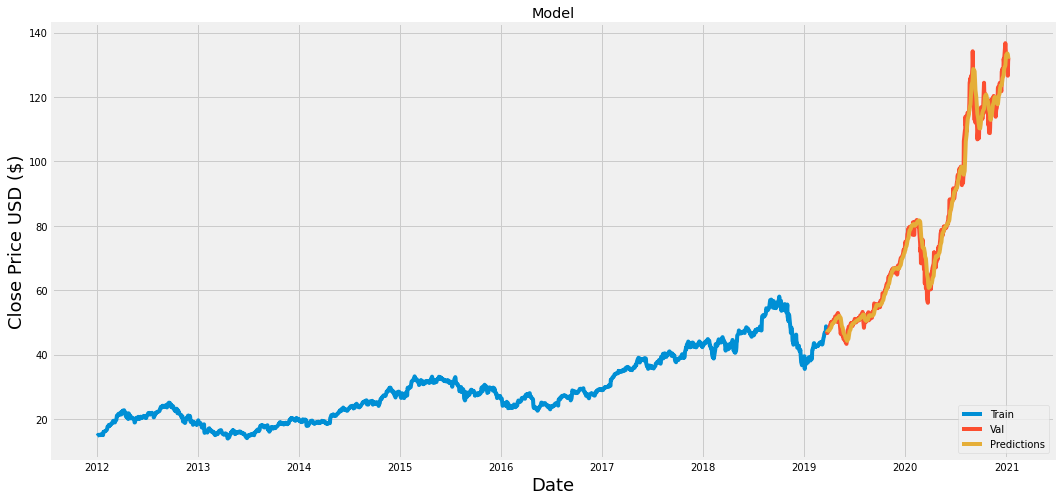

In [37]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [24]:
valid

,Close,Predictions
Date,,
2019-03-25,47.185001,46.926010
2019-03-26,46.697498,47.209641
2019-03-27,47.117500,47.342457
2019-03-28,47.180000,47.410934
2019-03-29,47.487499,47.437618
...,...,...
2021-01-04,129.410004,133.528488
2021-01-05,131.009995,133.406860
2021-01-06,126.599998,133.168900


Here we get the quote again. Create the a new dataframe, and naame it close, we get the last 60 days closing price, scale the data to be values between 0 and 1, create an empty list, append teh past 60 days, convert the X_test data set to a numpy array, reshape the data, get the predicted scaled price, undo the scaling

In [36]:
apple_quote = web.DataReader('AAPL', data_source='yahoo', start='2012-01-01', end='2021-02-20 ')

new_df = apple_quote.filter(['Close'])

last_60_days = new_df[-60:].values

last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []

X_test.append(last_60_days_scaled)

X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

pred_price = model.predict(X_test)

pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[131.60771]]


Finally, we get the quote 

In [33]:
apple_quote2 = web.DataReader('AAPL', data_source='yahoo', start='2020-12-31', end='2021-01-30')
print(apple_quote2['Close'])

Date
2020-12-31    132.690002
2021-01-04    129.410004
2021-01-05    131.009995
2021-01-06    126.599998
2021-01-07    130.919998
2021-01-08    132.050003
Name: Close, dtype: float64


# Reference
https://www.youtube.com/watch?v=QIUxPv5PJOY